### This notebook includes a few techniques for visualizing CNN activations and gradients, implemented in pytorch

### References
    http://blog.qure.ai/notes/deep-learning-visualization-gradient-based-methods
    
    http://gradcam.cloudcv.org/
    
    https://github.com/SharadGitHub/pytorch-cnn-visualizations

In [44]:
import os
import cv2
import numpy as np
import torchvision.datasets as datasets
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torchvision import models
import torchvision.transforms as transforms
from misc_functions import (preprocess_image, recreate_image, save_image, get_example_params, save_class_activation_images,
                            convert_to_grayscale, save_gradient_images, get_positive_negative_saliency)
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image


%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 5, 5

### Vanilla gradients visualization

In [74]:
class Vanilla_gradients:
    
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.model.eval()
        #hook the first layer of the model
        self.hook_layer()
        
    def hook_layer(self):
        
        def hook_fn(module, grad_in, grad_out):
            print("grad_in shape: ", type(grad_in))
            self.gradients = grad_in[0]
            
        self.model.features[0].register_backward_hook(hook_fn)
        
        
    def generate_gradients(self, input_image, output_class):
        
        model_output = self.model(input_image)
        self.model.zero_grad()
        
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][output_class] = 1
        # Backward pass
        #now we want to calculate the gradients of network output wrt to only target class
        model_output.backward(gradient=one_hot_output)
        
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr
        

In [75]:
# Get params
target_example = 1  # cat_dog image
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) = get_example_params(target_example)
# Vanilla backprop
VBP = Vanilla_gradients(pretrained_model)
# Generate gradients
vanilla_grads = VBP.generate_gradients(prep_img, target_class)
    
# Save colored gradients
save_gradient_images(vanilla_grads, file_name_to_export + '_Vanilla_BP_color')
# Convert to grayscale
grayscale_vanilla_grads = convert_to_grayscale(vanilla_grads)
# Save grayscale gradients
save_gradient_images(grayscale_vanilla_grads, file_name_to_export + '_Vanilla_BP_gray')
print('Vanilla backprop completed')


grad_in shape:  <class 'tuple'>
Vanilla backprop completed


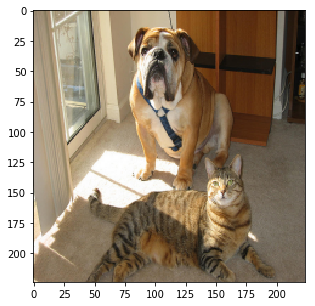

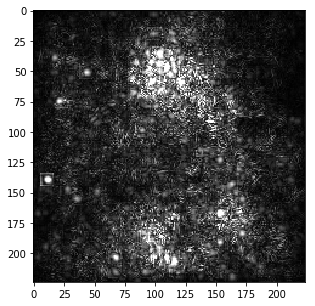

In [79]:
fig = plt.figure()
plt.imshow(original_image)

fig = plt.figure()
plt.imshow(grayscale_vanilla_grads[0], cmap = 'gray')


### Guided backrop

In [55]:
class guided_backprop:
    
    def __init__(self, model):
        
        self.model = model
        self.gradients = None
        self.activations = []
        self.model.eval()
        self.update_relus()
        self.hook_layer()
        
    def hook_layer(self):
        def hook_fn(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        
        first_layer = list(self.model.features)[0]
        first_layer.register_backward_hook(hook_fn)
        
    def update_relus(self):
        
        
        def relu_backward_hook(module, grad_in, grad_out):
            
            #change negative gradient value to zero
            
            activation = self.activations[-1]
            activation[activation > 0] = 1
            modified_grad_out = activation * torch.clamp(grad_in[0], min = 0.0)
            del self.activations[-1]
            return (modified_grad_out,)
            
            
        def relu_forward_hook(module, ten_in, ten_out):
            self.activations.append(ten_out)
            
        #these two updates have to be hook on each layer 
        for layer in list(self.model.features):
            if isinstance(layer, nn.ReLU):
                
                layer.register_forward_hook(relu_forward_hook)
                layer.register_backward_hook(relu_backward_hook)
        
        
    def generate_gradients(self, input_image, label):
        
        output = self.model(input_image)
        self.model.zero_grad()
        
        one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
        one_hot_output[0][label] = 1
        output.backward(gradient = one_hot_output)
        
        return self.gradients.data.numpy()[0]

In [80]:
target_example = 1  # Snake
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)

# Guided backprop
GBP = guided_backprop(pretrained_model)
# Get gradients
guided_grads = GBP.generate_gradients(prep_img, target_class)
# Save colored gradients
save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color')
# Convert to grayscale
grayscale_guided_grads = convert_to_grayscale(guided_grads)

# Save grayscale gradients
save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')
# Positive and negative saliency maps
pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')
print('Guided backprop completed')

Guided backprop completed


In [85]:
neg_sal.shape

(3, 224, 224)

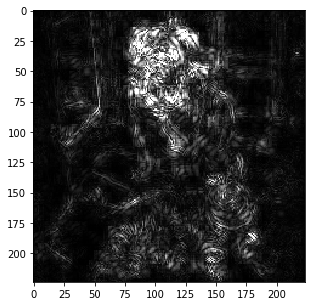

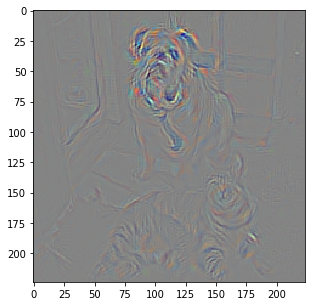

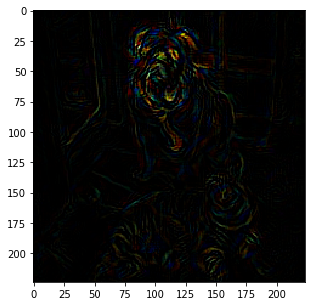

In [86]:

fig = plt.figure()
plt.imshow(grayscale_guided_grads[0], cmap = "gray")

guided_grads = (guided_grads - np.min(guided_grads)) / (np.max(guided_grads) - np.min(guided_grads))  # Normalize between 0-1
guided_grads = np.uint8(guided_grads * 255)
fig = plt.figure()
plt.imshow(guided_grads.transpose(1,2,0))

fig = plt.figure()
plt.imshow(neg_sal.transpose(1,2,0))

### Grad CAM

In [49]:
class CamExtractor:
    
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        
    def save_gradient(self, grad):
        self.gradients = grad
        
    def forward_pass_on_conv(self, x):
        
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x
    
    def forward_pass(self, x):
        
        conv_output, x = self.forward_pass_on_conv(x)
        x = x.view(x.size()[0], -1)
        x = self.model.classifier(x)
        return conv_output, x
    
    
class GradCam():
    
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)
        
    def generate_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Zero grads
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data.numpy()[0]
        print("gradients shape", guided_gradients.shape)
        
        # Get convolution outputs
        target = conv_output.data.numpy()[0]
        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        print("weights shape: ", weights.shape)
        
        # Create empty numpy array for cam
        print("conv ouput shape", target.shape)
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
            
        print("finally came shape", cam.shape)
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        #cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       #input_image.shape[3]), Image.ANTIALIAS))/255
        cam = cv2.resize(cam, (input_image.shape[2], input_image.shape[3]), interpolation = cv2.INTER_CUBIC  )
       
        return cam

In [89]:
# Get params
target_example = 1  # Snake
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)
# Grad cam
grad_cam = GradCam(pretrained_model, target_layer=11)
# Generate cam mask
cam = grad_cam.generate_cam(prep_img, target_class)
# Save mask
save_class_activation_images(original_image, cam, file_name_to_export)
print('Grad cam completed')

gradients shape (256, 13, 13)
weights shape:  (256,)
conv ouput shape (256, 13, 13)
finally came shape (13, 13)
Grad cam completed


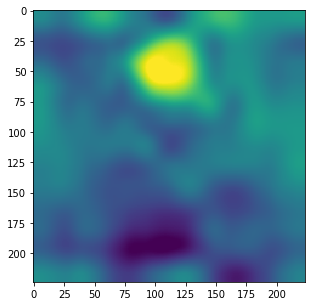

In [90]:
fig = plt.figure()
plt.imshow(cam)


### Guided grad cam

In [91]:
def guided_grad_cam(grad_cam_mask, guided_backprop_mask):
    """
        Guided grad cam is just pointwise multiplication of cam mask and
        guided backprop mask
    Args:
        grad_cam_mask (np_arr): Class activation map mask
        guided_backprop_mask (np_arr):Guided backprop mask
    """
    cam_gb = np.multiply(grad_cam_mask, guided_backprop_mask)
    return cam_gb

In [92]:
# Grad cam
gcv2 = GradCam(pretrained_model, target_layer=11)
# Generate cam mask
cam = gcv2.generate_cam(prep_img, target_class)
print('Grad cam completed')

# Guided backprop
GBP = guided_backprop(pretrained_model)
# Get gradients
guided_grads = GBP.generate_gradients(prep_img, target_class)
print('Guided backpropagation completed')

# Guided Grad cam
cam_gb = guided_grad_cam(cam, guided_grads)
save_gradient_images(cam_gb, file_name_to_export + '_GGrad_Cam')
grayscale_cam_gb = convert_to_grayscale(cam_gb)
save_gradient_images(grayscale_cam_gb, file_name_to_export + '_GGrad_Cam_gray')
print('Guided grad cam completed')

gradients shape (256, 13, 13)
weights shape:  (256,)
conv ouput shape (256, 13, 13)
finally came shape (13, 13)
Grad cam completed
Guided backpropagation completed
Guided grad cam completed


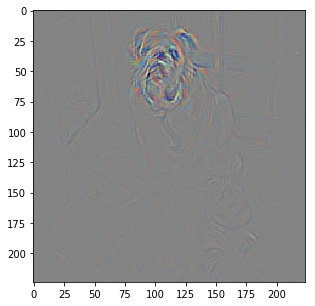

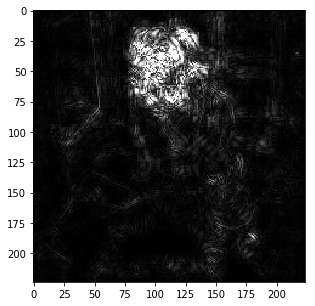

In [97]:
#cam = np.maximum(cam, 0)
cam_gb = (cam_gb - np.min(cam_gb)) / (np.max(cam_gb) - np.min(cam_gb))  # Normalize between 0-1
cam_gb = np.uint8(cam_gb * 255)

fig = plt.figure()
plt.imshow(cam_gb.transpose(1,2,0))

fig = plt.figure()
plt.imshow(grayscale_cam_gb[0], cmap = "gray")
